# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

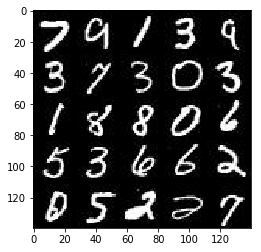

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

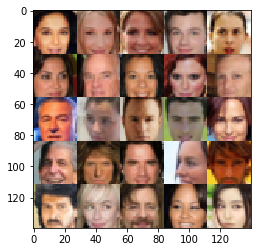

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_r = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learn_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Hyperparameters

In [7]:
alpha = 0.1 # for leaky relu
print_every = 10
show_every = 100 #change to 100

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='valid')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1)
        # 24x24x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        # 20x20x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3)
        # 16x16x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='valid')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #print(relu4)
        # 6x6x512

        # Flatten it
        flat = tf.reshape(relu4, (-1, 6*6*512))
        logits = tf.layers.dense(flat, 1)
        #print(flat)
        out = tf.sigmoid(logits)
       
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
 
    with tf.variable_scope('generator', reuse=not is_train):
      
        # First fully connected layer
        fc = tf.layers.dense(z, 7*7*1024)
        fc = tf.reshape(fc, (-1, 7, 7, 1024))
        fc = tf.maximum(alpha * fc, fc)
        #print(fc)
        # 7x7x1024 now
        
        # Reshape it to start the convolutional stack
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        
        
        
        # Deconv1
        dconv1 = tf.layers.conv2d_transpose(fc, 512, 3, strides=2, padding='same')
        dconv1 = tf.layers.batch_normalization(dconv1, training=is_train)
        dconv1 = tf.maximum(alpha * dconv1, dconv1)
        #print(dconv1)
        # 14x14x512 now
        
        dconv2 = tf.layers.conv2d_transpose(dconv1, 256, 3, strides=2, padding='same')
        dconv2 = tf.layers.batch_normalization(dconv2, training=is_train)
        dconv2 = tf.maximum(alpha * dconv2, dconv2)
        #print(dconv2)
        # 28x28x256 now
        
        dconv3 = tf.layers.conv2d_transpose(dconv2, 128, 5, strides=1, padding='same')
        dconv3 = tf.layers.batch_normalization(dconv3, training=is_train)
        dconv3 = tf.maximum(alpha * dconv3, dconv3)
        #print(dconv3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(dconv3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits)
        # 28x28x(channels) now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
from IPython.core.debugger import Tracer

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # create input placeholders
    #print(data_shape)
    image_shape = data_shape[1:]
    #print(image_shape)
    out_channel_dim = image_shape[-1]
    #print(out_channel_dim)
    
    inputs_real, inputs_z, lr_rate = model_inputs(*image_shape, z_dim)
    #print(inputs_real)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    #print(inputs_real)
    
    #t_vars = tf.trainable_variables()
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    #saver = tf.train.Saver(var_list=g_vars)
    
    def scale(x, target_range=(-1,1)):
        min, max = target_range
        
        # One liner, but too expensive 
        #x = (x - x.min()) * (max - min) / (x.max() - x.min()) + min
        
        # First scale to [0,1]
        x = ((x - x.min())/(x.max() - x.min()))
    
        # Then scale to target_range
        min, max = target_range
        x = x * (max - min) + min
        return x
    
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #print("Step {} ...".format(steps))
                
                #1 Scale real images to [-1,1] range since that is also the generator output scale
                batch_images = scale(batch_images, target_range=(-1,1))
                
                
                #3 Sample random noise for generator
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                
                #3 Run optimizers
                #print(batch_images.shape)
                            
                
                # Optimize discriminator
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     lr_rate: learning_rate})
                
                
                
                
                # Optimize generator (Run twice to avoid faster convergence of D)
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z,
                                                     inputs_real: batch_images,
                                                     lr_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z,
                                                     inputs_real: batch_images,
                                                     lr_rate: learning_rate})
                
                
                #Tracer()() #this one triggers the debugger
                if steps % print_every == 0:
                    
                    d_train_loss = d_loss.eval({inputs_real: batch_images,
                                                inputs_z: batch_z,
                                                lr_rate: learning_rate})
                
                    # Optimize generator
                    g_train_loss = g_loss.eval({inputs_z: batch_z,
                                                inputs_real: batch_images,
                                                lr_rate: learning_rate})
                    
                    #Tracer()() #this one triggers the debugger
                    print("Epoch {}/{}-Step {}...".format(epoch_i+1, epoch_count,steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                if steps % show_every == 0:
                        show_generator_output(sess, 9, inputs_z, out_channel_dim, data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2-Step 10... Discriminator Loss: 0.9267... Generator Loss: 3.0303
Epoch 1/2-Step 20... Discriminator Loss: 0.0128... Generator Loss: 5.2754
Epoch 1/2-Step 30... Discriminator Loss: 1.0608... Generator Loss: 2.6022
Epoch 1/2-Step 40... Discriminator Loss: 1.6446... Generator Loss: 1.1610
Epoch 1/2-Step 50... Discriminator Loss: 1.0090... Generator Loss: 1.2422
Epoch 1/2-Step 60... Discriminator Loss: 1.1629... Generator Loss: 1.4662
Epoch 1/2-Step 70... Discriminator Loss: 1.5492... Generator Loss: 1.4174
Epoch 1/2-Step 80... Discriminator Loss: 1.3179... Generator Loss: 0.9317
Epoch 1/2-Step 90... Discriminator Loss: 1.7052... Generator Loss: 1.2884
Epoch 1/2-Step 100... Discriminator Loss: 2.0016... Generator Loss: 0.2221


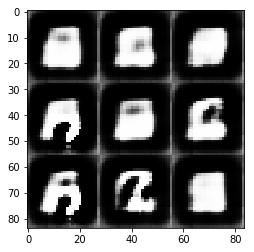

Epoch 1/2-Step 110... Discriminator Loss: 1.0928... Generator Loss: 3.6356
Epoch 1/2-Step 120... Discriminator Loss: 1.8290... Generator Loss: 0.5105
Epoch 1/2-Step 130... Discriminator Loss: 1.8758... Generator Loss: 0.6536
Epoch 1/2-Step 140... Discriminator Loss: 0.9872... Generator Loss: 1.5308
Epoch 1/2-Step 150... Discriminator Loss: 0.8386... Generator Loss: 3.2762
Epoch 1/2-Step 160... Discriminator Loss: 0.4610... Generator Loss: 1.8612
Epoch 1/2-Step 170... Discriminator Loss: 0.8992... Generator Loss: 3.7001
Epoch 1/2-Step 180... Discriminator Loss: 0.3389... Generator Loss: 3.2347
Epoch 1/2-Step 190... Discriminator Loss: 1.2121... Generator Loss: 0.9055
Epoch 1/2-Step 200... Discriminator Loss: 3.2045... Generator Loss: 0.0909


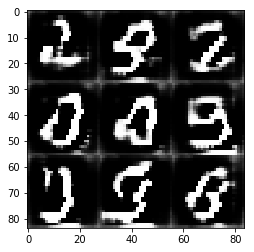

Epoch 1/2-Step 210... Discriminator Loss: 1.3834... Generator Loss: 3.7705
Epoch 1/2-Step 220... Discriminator Loss: 0.8444... Generator Loss: 1.6745
Epoch 1/2-Step 230... Discriminator Loss: 0.3921... Generator Loss: 1.8625
Epoch 1/2-Step 240... Discriminator Loss: 0.6757... Generator Loss: 1.7159
Epoch 1/2-Step 250... Discriminator Loss: 0.8184... Generator Loss: 1.3769
Epoch 1/2-Step 260... Discriminator Loss: 0.3848... Generator Loss: 2.3387
Epoch 1/2-Step 270... Discriminator Loss: 0.4555... Generator Loss: 2.0942
Epoch 1/2-Step 280... Discriminator Loss: 2.1406... Generator Loss: 0.5748
Epoch 1/2-Step 290... Discriminator Loss: 0.2285... Generator Loss: 2.4981
Epoch 1/2-Step 300... Discriminator Loss: 1.9429... Generator Loss: 0.4845


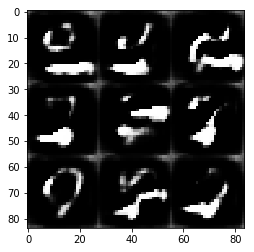

Epoch 1/2-Step 310... Discriminator Loss: 1.4466... Generator Loss: 1.9327
Epoch 1/2-Step 320... Discriminator Loss: 0.9744... Generator Loss: 0.8699
Epoch 1/2-Step 330... Discriminator Loss: 1.4074... Generator Loss: 1.3701
Epoch 1/2-Step 340... Discriminator Loss: 1.0074... Generator Loss: 1.0729
Epoch 1/2-Step 350... Discriminator Loss: 0.4718... Generator Loss: 2.2176
Epoch 1/2-Step 360... Discriminator Loss: 1.0672... Generator Loss: 0.8503
Epoch 1/2-Step 370... Discriminator Loss: 1.8639... Generator Loss: 0.4736
Epoch 1/2-Step 380... Discriminator Loss: 1.0121... Generator Loss: 0.9073
Epoch 1/2-Step 390... Discriminator Loss: 0.3627... Generator Loss: 4.4332
Epoch 1/2-Step 400... Discriminator Loss: 2.8513... Generator Loss: 0.1151


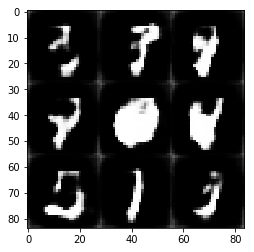

Epoch 1/2-Step 410... Discriminator Loss: 1.6384... Generator Loss: 0.4555
Epoch 1/2-Step 420... Discriminator Loss: 1.0845... Generator Loss: 0.9582
Epoch 1/2-Step 430... Discriminator Loss: 2.6283... Generator Loss: 0.2061
Epoch 1/2-Step 440... Discriminator Loss: 2.0905... Generator Loss: 0.2952
Epoch 1/2-Step 450... Discriminator Loss: 3.3657... Generator Loss: 0.1126
Epoch 1/2-Step 460... Discriminator Loss: 0.8958... Generator Loss: 0.8718
Epoch 1/2-Step 470... Discriminator Loss: 3.1746... Generator Loss: 0.0618
Epoch 1/2-Step 480... Discriminator Loss: 1.5734... Generator Loss: 0.5139
Epoch 1/2-Step 490... Discriminator Loss: 0.7358... Generator Loss: 2.6876
Epoch 1/2-Step 500... Discriminator Loss: 1.1104... Generator Loss: 2.3262


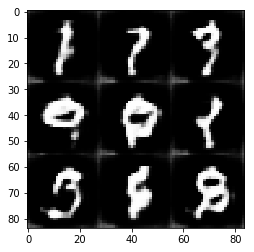

Epoch 1/2-Step 510... Discriminator Loss: 1.3891... Generator Loss: 0.5434
Epoch 1/2-Step 520... Discriminator Loss: 1.4872... Generator Loss: 0.8000
Epoch 1/2-Step 530... Discriminator Loss: 0.7497... Generator Loss: 1.9807
Epoch 1/2-Step 540... Discriminator Loss: 1.5252... Generator Loss: 1.0185
Epoch 1/2-Step 550... Discriminator Loss: 1.4869... Generator Loss: 0.4923
Epoch 1/2-Step 560... Discriminator Loss: 0.9228... Generator Loss: 2.2592
Epoch 1/2-Step 570... Discriminator Loss: 0.8381... Generator Loss: 1.1396
Epoch 1/2-Step 580... Discriminator Loss: 0.5408... Generator Loss: 1.6971
Epoch 1/2-Step 590... Discriminator Loss: 3.1695... Generator Loss: 4.3885
Epoch 1/2-Step 600... Discriminator Loss: 1.1400... Generator Loss: 1.2354


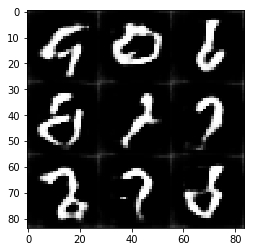

Epoch 1/2-Step 610... Discriminator Loss: 1.2808... Generator Loss: 0.7663
Epoch 1/2-Step 620... Discriminator Loss: 1.1544... Generator Loss: 1.6539
Epoch 1/2-Step 630... Discriminator Loss: 2.0728... Generator Loss: 0.2722
Epoch 1/2-Step 640... Discriminator Loss: 2.4404... Generator Loss: 2.0143
Epoch 1/2-Step 650... Discriminator Loss: 1.0015... Generator Loss: 1.1314
Epoch 1/2-Step 660... Discriminator Loss: 2.2646... Generator Loss: 0.2215
Epoch 1/2-Step 670... Discriminator Loss: 0.8644... Generator Loss: 1.3619
Epoch 1/2-Step 680... Discriminator Loss: 2.0751... Generator Loss: 0.4561
Epoch 1/2-Step 690... Discriminator Loss: 1.0712... Generator Loss: 1.1022
Epoch 1/2-Step 700... Discriminator Loss: 0.8807... Generator Loss: 3.1525


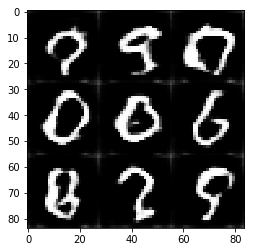

Epoch 1/2-Step 710... Discriminator Loss: 1.4505... Generator Loss: 1.3298
Epoch 1/2-Step 720... Discriminator Loss: 1.6401... Generator Loss: 1.3325
Epoch 1/2-Step 730... Discriminator Loss: 2.1060... Generator Loss: 3.4476
Epoch 1/2-Step 740... Discriminator Loss: 1.3121... Generator Loss: 0.8670
Epoch 1/2-Step 750... Discriminator Loss: 1.2358... Generator Loss: 2.5686
Epoch 1/2-Step 760... Discriminator Loss: 2.6190... Generator Loss: 0.1099
Epoch 1/2-Step 770... Discriminator Loss: 1.5482... Generator Loss: 2.8853
Epoch 1/2-Step 780... Discriminator Loss: 2.5531... Generator Loss: 0.1868
Epoch 1/2-Step 790... Discriminator Loss: 1.1788... Generator Loss: 0.8387
Epoch 1/2-Step 800... Discriminator Loss: 0.6670... Generator Loss: 1.3919


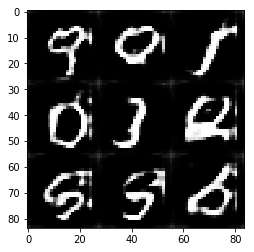

Epoch 1/2-Step 810... Discriminator Loss: 1.8112... Generator Loss: 0.5763
Epoch 1/2-Step 820... Discriminator Loss: 1.4400... Generator Loss: 0.8454
Epoch 1/2-Step 830... Discriminator Loss: 2.1204... Generator Loss: 0.1975
Epoch 1/2-Step 840... Discriminator Loss: 0.9309... Generator Loss: 0.8856
Epoch 1/2-Step 850... Discriminator Loss: 2.2666... Generator Loss: 0.2093
Epoch 1/2-Step 860... Discriminator Loss: 2.7204... Generator Loss: 0.2036
Epoch 1/2-Step 870... Discriminator Loss: 1.4407... Generator Loss: 0.7119
Epoch 1/2-Step 880... Discriminator Loss: 1.8585... Generator Loss: 0.3937
Epoch 1/2-Step 890... Discriminator Loss: 1.1191... Generator Loss: 1.4012
Epoch 1/2-Step 900... Discriminator Loss: 1.9723... Generator Loss: 2.9803


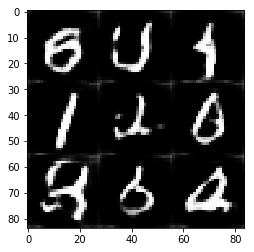

Epoch 1/2-Step 910... Discriminator Loss: 1.3118... Generator Loss: 2.4486
Epoch 1/2-Step 920... Discriminator Loss: 1.2882... Generator Loss: 0.5410
Epoch 1/2-Step 930... Discriminator Loss: 3.1985... Generator Loss: 0.1271
Epoch 1/2-Step 940... Discriminator Loss: 2.2658... Generator Loss: 0.2157
Epoch 1/2-Step 950... Discriminator Loss: 1.4683... Generator Loss: 0.6122
Epoch 1/2-Step 960... Discriminator Loss: 1.3805... Generator Loss: 0.5894
Epoch 1/2-Step 970... Discriminator Loss: 0.9084... Generator Loss: 1.3491
Epoch 1/2-Step 980... Discriminator Loss: 1.1829... Generator Loss: 0.8846
Epoch 1/2-Step 990... Discriminator Loss: 2.6936... Generator Loss: 0.1252
Epoch 1/2-Step 1000... Discriminator Loss: 1.0920... Generator Loss: 3.3635


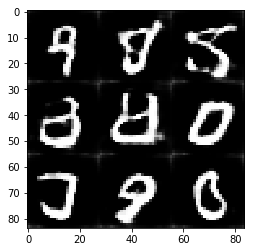

Epoch 1/2-Step 1010... Discriminator Loss: 0.4717... Generator Loss: 2.0444
Epoch 1/2-Step 1020... Discriminator Loss: 2.2474... Generator Loss: 3.6244
Epoch 1/2-Step 1030... Discriminator Loss: 1.1826... Generator Loss: 1.1267
Epoch 1/2-Step 1040... Discriminator Loss: 0.8570... Generator Loss: 1.7126
Epoch 1/2-Step 1050... Discriminator Loss: 1.2136... Generator Loss: 0.6905
Epoch 1/2-Step 1060... Discriminator Loss: 1.0117... Generator Loss: 0.8767
Epoch 1/2-Step 1070... Discriminator Loss: 1.6421... Generator Loss: 0.4355
Epoch 1/2-Step 1080... Discriminator Loss: 3.1265... Generator Loss: 0.1189
Epoch 1/2-Step 1090... Discriminator Loss: 1.5463... Generator Loss: 0.5217
Epoch 1/2-Step 1100... Discriminator Loss: 1.9496... Generator Loss: 0.3557


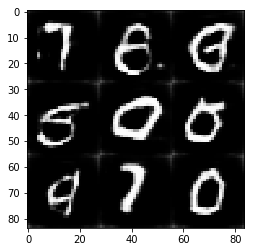

Epoch 1/2-Step 1110... Discriminator Loss: 1.0777... Generator Loss: 0.8982
Epoch 1/2-Step 1120... Discriminator Loss: 0.8473... Generator Loss: 2.6787
Epoch 1/2-Step 1130... Discriminator Loss: 2.1421... Generator Loss: 0.4104
Epoch 1/2-Step 1140... Discriminator Loss: 0.5819... Generator Loss: 1.3670
Epoch 1/2-Step 1150... Discriminator Loss: 0.4012... Generator Loss: 3.8247
Epoch 1/2-Step 1160... Discriminator Loss: 1.8693... Generator Loss: 0.3963
Epoch 1/2-Step 1170... Discriminator Loss: 1.1938... Generator Loss: 0.7962
Epoch 1/2-Step 1180... Discriminator Loss: 0.6501... Generator Loss: 1.2007
Epoch 1/2-Step 1190... Discriminator Loss: 2.0899... Generator Loss: 0.3304
Epoch 1/2-Step 1200... Discriminator Loss: 1.8512... Generator Loss: 0.6061


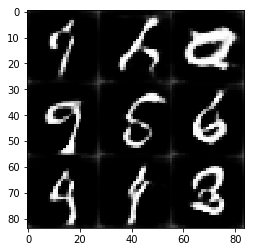

Epoch 1/2-Step 1210... Discriminator Loss: 2.4600... Generator Loss: 0.2065
Epoch 1/2-Step 1220... Discriminator Loss: 1.1053... Generator Loss: 1.4613
Epoch 1/2-Step 1230... Discriminator Loss: 3.1921... Generator Loss: 0.1285
Epoch 1/2-Step 1240... Discriminator Loss: 2.4057... Generator Loss: 0.2731
Epoch 1/2-Step 1250... Discriminator Loss: 0.9394... Generator Loss: 2.9006
Epoch 1/2-Step 1260... Discriminator Loss: 0.8145... Generator Loss: 1.2383
Epoch 1/2-Step 1270... Discriminator Loss: 0.3363... Generator Loss: 1.9907
Epoch 1/2-Step 1280... Discriminator Loss: 2.1134... Generator Loss: 0.2527
Epoch 1/2-Step 1290... Discriminator Loss: 4.0813... Generator Loss: 0.0666
Epoch 1/2-Step 1300... Discriminator Loss: 0.5599... Generator Loss: 2.2968


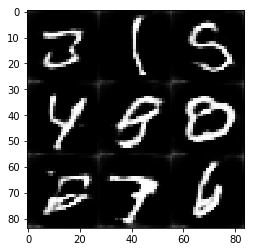

Epoch 1/2-Step 1310... Discriminator Loss: 2.8760... Generator Loss: 0.2637
Epoch 1/2-Step 1320... Discriminator Loss: 1.3657... Generator Loss: 1.6037
Epoch 1/2-Step 1330... Discriminator Loss: 1.3713... Generator Loss: 0.7570
Epoch 1/2-Step 1340... Discriminator Loss: 2.7794... Generator Loss: 0.2296
Epoch 1/2-Step 1350... Discriminator Loss: 1.6856... Generator Loss: 0.4993
Epoch 1/2-Step 1360... Discriminator Loss: 0.5796... Generator Loss: 1.5256
Epoch 1/2-Step 1370... Discriminator Loss: 1.6392... Generator Loss: 1.6606
Epoch 1/2-Step 1380... Discriminator Loss: 0.8350... Generator Loss: 1.6210
Epoch 1/2-Step 1390... Discriminator Loss: 2.5282... Generator Loss: 0.2095
Epoch 1/2-Step 1400... Discriminator Loss: 1.0859... Generator Loss: 1.1357


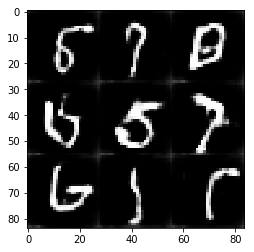

Epoch 1/2-Step 1410... Discriminator Loss: 1.1798... Generator Loss: 0.9080
Epoch 1/2-Step 1420... Discriminator Loss: 1.3249... Generator Loss: 0.7105
Epoch 1/2-Step 1430... Discriminator Loss: 0.8106... Generator Loss: 1.0409
Epoch 1/2-Step 1440... Discriminator Loss: 3.8837... Generator Loss: 0.0626
Epoch 1/2-Step 1450... Discriminator Loss: 0.9882... Generator Loss: 0.8990
Epoch 1/2-Step 1460... Discriminator Loss: 2.3555... Generator Loss: 0.2031
Epoch 1/2-Step 1470... Discriminator Loss: 1.1362... Generator Loss: 0.7481
Epoch 1/2-Step 1480... Discriminator Loss: 3.1776... Generator Loss: 0.1075
Epoch 1/2-Step 1490... Discriminator Loss: 1.3520... Generator Loss: 1.5787
Epoch 1/2-Step 1500... Discriminator Loss: 1.0190... Generator Loss: 1.8918


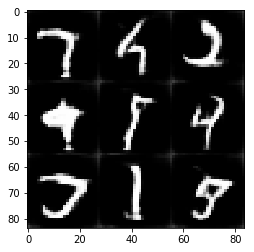

Epoch 1/2-Step 1510... Discriminator Loss: 1.3130... Generator Loss: 3.2561
Epoch 1/2-Step 1520... Discriminator Loss: 1.3796... Generator Loss: 0.5629
Epoch 1/2-Step 1530... Discriminator Loss: 1.6151... Generator Loss: 0.6132
Epoch 1/2-Step 1540... Discriminator Loss: 1.0203... Generator Loss: 1.5598
Epoch 1/2-Step 1550... Discriminator Loss: 0.7105... Generator Loss: 1.3498
Epoch 1/2-Step 1560... Discriminator Loss: 1.7961... Generator Loss: 0.4888
Epoch 1/2-Step 1570... Discriminator Loss: 1.2594... Generator Loss: 2.2816
Epoch 1/2-Step 1580... Discriminator Loss: 1.1150... Generator Loss: 0.7396
Epoch 1/2-Step 1590... Discriminator Loss: 1.3450... Generator Loss: 0.7354
Epoch 1/2-Step 1600... Discriminator Loss: 1.4369... Generator Loss: 0.6458


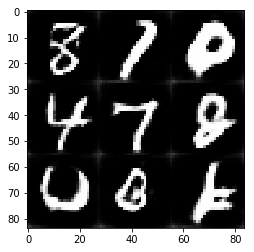

Epoch 1/2-Step 1610... Discriminator Loss: 1.7995... Generator Loss: 0.3567
Epoch 1/2-Step 1620... Discriminator Loss: 1.0228... Generator Loss: 0.8237
Epoch 1/2-Step 1630... Discriminator Loss: 2.8634... Generator Loss: 0.1942
Epoch 1/2-Step 1640... Discriminator Loss: 2.6316... Generator Loss: 0.2240
Epoch 1/2-Step 1650... Discriminator Loss: 1.7795... Generator Loss: 4.5748
Epoch 1/2-Step 1660... Discriminator Loss: 1.5611... Generator Loss: 0.6124
Epoch 1/2-Step 1670... Discriminator Loss: 0.7054... Generator Loss: 1.4339
Epoch 1/2-Step 1680... Discriminator Loss: 2.1514... Generator Loss: 0.3458
Epoch 1/2-Step 1690... Discriminator Loss: 1.7364... Generator Loss: 0.4061
Epoch 1/2-Step 1700... Discriminator Loss: 3.0349... Generator Loss: 0.1355


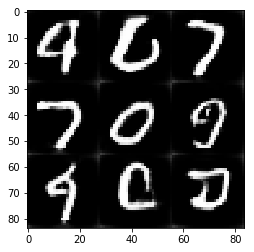

Epoch 1/2-Step 1710... Discriminator Loss: 0.9496... Generator Loss: 0.8696
Epoch 1/2-Step 1720... Discriminator Loss: 1.4395... Generator Loss: 0.6739
Epoch 1/2-Step 1730... Discriminator Loss: 0.6664... Generator Loss: 1.6997
Epoch 1/2-Step 1740... Discriminator Loss: 2.6954... Generator Loss: 0.2849
Epoch 1/2-Step 1750... Discriminator Loss: 1.3603... Generator Loss: 0.9009
Epoch 1/2-Step 1760... Discriminator Loss: 1.0816... Generator Loss: 0.9107
Epoch 1/2-Step 1770... Discriminator Loss: 0.8256... Generator Loss: 1.0552
Epoch 1/2-Step 1780... Discriminator Loss: 0.4205... Generator Loss: 1.9499
Epoch 1/2-Step 1790... Discriminator Loss: 1.6130... Generator Loss: 0.3562
Epoch 1/2-Step 1800... Discriminator Loss: 2.5861... Generator Loss: 0.1800


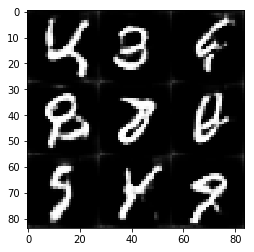

Epoch 1/2-Step 1810... Discriminator Loss: 1.5904... Generator Loss: 0.5657
Epoch 1/2-Step 1820... Discriminator Loss: 2.0948... Generator Loss: 0.2882
Epoch 1/2-Step 1830... Discriminator Loss: 1.0161... Generator Loss: 1.1578
Epoch 1/2-Step 1840... Discriminator Loss: 1.3440... Generator Loss: 0.5831
Epoch 1/2-Step 1850... Discriminator Loss: 1.0551... Generator Loss: 0.9924
Epoch 1/2-Step 1860... Discriminator Loss: 1.3557... Generator Loss: 0.5949
Epoch 1/2-Step 1870... Discriminator Loss: 2.1658... Generator Loss: 0.7761
Epoch 2/2-Step 1880... Discriminator Loss: 1.7988... Generator Loss: 0.6089
Epoch 2/2-Step 1890... Discriminator Loss: 1.3895... Generator Loss: 1.2412
Epoch 2/2-Step 1900... Discriminator Loss: 1.1182... Generator Loss: 1.1952


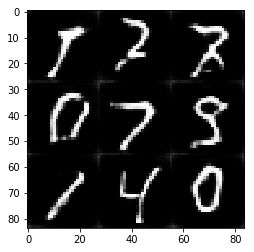

Epoch 2/2-Step 1910... Discriminator Loss: 1.4968... Generator Loss: 0.5684
Epoch 2/2-Step 1920... Discriminator Loss: 1.4977... Generator Loss: 0.6296
Epoch 2/2-Step 1930... Discriminator Loss: 1.9247... Generator Loss: 0.2941
Epoch 2/2-Step 1940... Discriminator Loss: 0.8135... Generator Loss: 1.0944
Epoch 2/2-Step 1950... Discriminator Loss: 2.9539... Generator Loss: 0.1693
Epoch 2/2-Step 1960... Discriminator Loss: 1.6268... Generator Loss: 0.4130
Epoch 2/2-Step 1970... Discriminator Loss: 2.4348... Generator Loss: 0.1656
Epoch 2/2-Step 1980... Discriminator Loss: 1.0910... Generator Loss: 1.1037
Epoch 2/2-Step 1990... Discriminator Loss: 2.4345... Generator Loss: 0.2697
Epoch 2/2-Step 2000... Discriminator Loss: 2.8119... Generator Loss: 0.1547


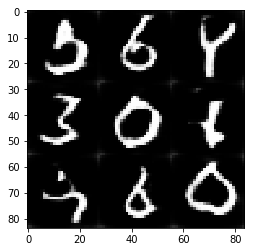

Epoch 2/2-Step 2010... Discriminator Loss: 2.9430... Generator Loss: 0.1119
Epoch 2/2-Step 2020... Discriminator Loss: 2.4929... Generator Loss: 0.2289
Epoch 2/2-Step 2030... Discriminator Loss: 1.3928... Generator Loss: 0.6620
Epoch 2/2-Step 2040... Discriminator Loss: 0.9953... Generator Loss: 0.9853
Epoch 2/2-Step 2050... Discriminator Loss: 2.0209... Generator Loss: 0.3261
Epoch 2/2-Step 2060... Discriminator Loss: 1.0119... Generator Loss: 1.4060
Epoch 2/2-Step 2070... Discriminator Loss: 2.3089... Generator Loss: 0.2537
Epoch 2/2-Step 2080... Discriminator Loss: 1.8246... Generator Loss: 3.4251
Epoch 2/2-Step 2090... Discriminator Loss: 3.6070... Generator Loss: 0.2074
Epoch 2/2-Step 2100... Discriminator Loss: 1.7052... Generator Loss: 1.4942


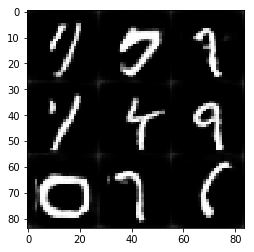

Epoch 2/2-Step 2110... Discriminator Loss: 1.7078... Generator Loss: 0.4842
Epoch 2/2-Step 2120... Discriminator Loss: 1.8781... Generator Loss: 0.3792
Epoch 2/2-Step 2130... Discriminator Loss: 0.9712... Generator Loss: 1.0053
Epoch 2/2-Step 2140... Discriminator Loss: 2.0136... Generator Loss: 0.3907
Epoch 2/2-Step 2150... Discriminator Loss: 2.0800... Generator Loss: 0.4026
Epoch 2/2-Step 2160... Discriminator Loss: 1.2040... Generator Loss: 0.6960
Epoch 2/2-Step 2170... Discriminator Loss: 0.4719... Generator Loss: 3.4201
Epoch 2/2-Step 2180... Discriminator Loss: 1.2094... Generator Loss: 0.7431
Epoch 2/2-Step 2190... Discriminator Loss: 1.9730... Generator Loss: 0.5210
Epoch 2/2-Step 2200... Discriminator Loss: 1.3208... Generator Loss: 0.9190


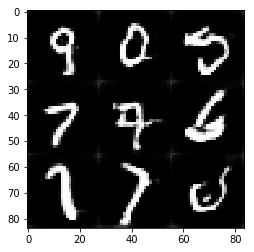

Epoch 2/2-Step 2210... Discriminator Loss: 0.9230... Generator Loss: 1.0733
Epoch 2/2-Step 2220... Discriminator Loss: 1.6415... Generator Loss: 0.4990
Epoch 2/2-Step 2230... Discriminator Loss: 1.2177... Generator Loss: 0.7985
Epoch 2/2-Step 2240... Discriminator Loss: 1.7188... Generator Loss: 0.4603
Epoch 2/2-Step 2250... Discriminator Loss: 1.0832... Generator Loss: 0.9234
Epoch 2/2-Step 2260... Discriminator Loss: 2.4330... Generator Loss: 0.2552
Epoch 2/2-Step 2270... Discriminator Loss: 1.0972... Generator Loss: 1.8646
Epoch 2/2-Step 2280... Discriminator Loss: 4.2175... Generator Loss: 0.0387
Epoch 2/2-Step 2290... Discriminator Loss: 1.4911... Generator Loss: 0.6146
Epoch 2/2-Step 2300... Discriminator Loss: 1.0731... Generator Loss: 1.9281


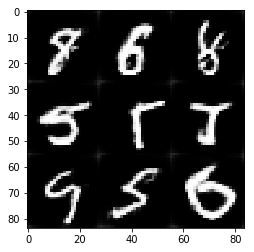

Epoch 2/2-Step 2310... Discriminator Loss: 2.6048... Generator Loss: 0.1825
Epoch 2/2-Step 2320... Discriminator Loss: 1.3122... Generator Loss: 0.5521
Epoch 2/2-Step 2330... Discriminator Loss: 1.3775... Generator Loss: 0.6418
Epoch 2/2-Step 2340... Discriminator Loss: 1.1761... Generator Loss: 0.7925
Epoch 2/2-Step 2350... Discriminator Loss: 1.1322... Generator Loss: 0.7320
Epoch 2/2-Step 2360... Discriminator Loss: 0.1161... Generator Loss: 3.6323
Epoch 2/2-Step 2370... Discriminator Loss: 1.0060... Generator Loss: 1.2201
Epoch 2/2-Step 2380... Discriminator Loss: 0.6671... Generator Loss: 1.1994
Epoch 2/2-Step 2390... Discriminator Loss: 3.2159... Generator Loss: 0.2751
Epoch 2/2-Step 2400... Discriminator Loss: 3.4933... Generator Loss: 0.0844


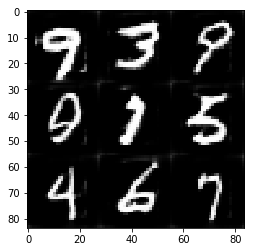

Epoch 2/2-Step 2410... Discriminator Loss: 0.9275... Generator Loss: 2.6940
Epoch 2/2-Step 2420... Discriminator Loss: 1.1644... Generator Loss: 0.7646
Epoch 2/2-Step 2430... Discriminator Loss: 1.8302... Generator Loss: 0.3799
Epoch 2/2-Step 2440... Discriminator Loss: 1.7304... Generator Loss: 0.3922
Epoch 2/2-Step 2450... Discriminator Loss: 2.1595... Generator Loss: 0.3598
Epoch 2/2-Step 2460... Discriminator Loss: 1.7138... Generator Loss: 1.4030
Epoch 2/2-Step 2470... Discriminator Loss: 1.2481... Generator Loss: 0.6815
Epoch 2/2-Step 2480... Discriminator Loss: 1.4053... Generator Loss: 0.7218
Epoch 2/2-Step 2490... Discriminator Loss: 3.3293... Generator Loss: 0.1335
Epoch 2/2-Step 2500... Discriminator Loss: 1.8164... Generator Loss: 0.5824


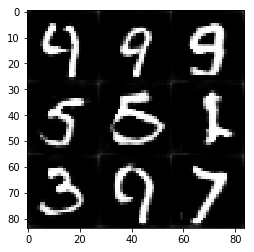

Epoch 2/2-Step 2510... Discriminator Loss: 2.6035... Generator Loss: 0.2349
Epoch 2/2-Step 2520... Discriminator Loss: 0.8650... Generator Loss: 4.0960
Epoch 2/2-Step 2530... Discriminator Loss: 1.5684... Generator Loss: 0.5153
Epoch 2/2-Step 2540... Discriminator Loss: 0.7783... Generator Loss: 1.2478
Epoch 2/2-Step 2550... Discriminator Loss: 2.4847... Generator Loss: 0.3230
Epoch 2/2-Step 2560... Discriminator Loss: 0.8980... Generator Loss: 4.6620
Epoch 2/2-Step 2570... Discriminator Loss: 1.3185... Generator Loss: 1.2826
Epoch 2/2-Step 2580... Discriminator Loss: 3.2025... Generator Loss: 0.2373
Epoch 2/2-Step 2590... Discriminator Loss: 2.0644... Generator Loss: 0.4936
Epoch 2/2-Step 2600... Discriminator Loss: 0.9851... Generator Loss: 1.2821


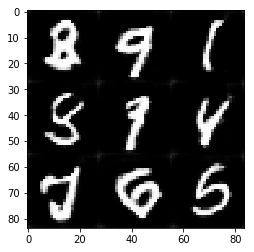

Epoch 2/2-Step 2610... Discriminator Loss: 1.7005... Generator Loss: 0.7132
Epoch 2/2-Step 2620... Discriminator Loss: 1.7881... Generator Loss: 0.4661
Epoch 2/2-Step 2630... Discriminator Loss: 1.1388... Generator Loss: 0.9582
Epoch 2/2-Step 2640... Discriminator Loss: 1.0748... Generator Loss: 2.2080
Epoch 2/2-Step 2650... Discriminator Loss: 1.4443... Generator Loss: 0.7525
Epoch 2/2-Step 2660... Discriminator Loss: 2.8320... Generator Loss: 0.1446
Epoch 2/2-Step 2670... Discriminator Loss: 1.6948... Generator Loss: 0.9054
Epoch 2/2-Step 2680... Discriminator Loss: 0.5985... Generator Loss: 1.3193
Epoch 2/2-Step 2690... Discriminator Loss: 1.9464... Generator Loss: 2.4039
Epoch 2/2-Step 2700... Discriminator Loss: 1.1410... Generator Loss: 0.8293


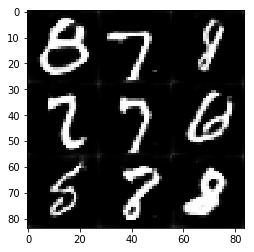

Epoch 2/2-Step 2710... Discriminator Loss: 0.9968... Generator Loss: 0.9076
Epoch 2/2-Step 2720... Discriminator Loss: 1.7824... Generator Loss: 0.5328
Epoch 2/2-Step 2730... Discriminator Loss: 0.2981... Generator Loss: 2.5057
Epoch 2/2-Step 2740... Discriminator Loss: 1.0728... Generator Loss: 0.9905
Epoch 2/2-Step 2750... Discriminator Loss: 1.5693... Generator Loss: 0.5073
Epoch 2/2-Step 2760... Discriminator Loss: 1.0690... Generator Loss: 3.7526
Epoch 2/2-Step 2770... Discriminator Loss: 2.4759... Generator Loss: 0.2352
Epoch 2/2-Step 2780... Discriminator Loss: 0.9367... Generator Loss: 2.4314
Epoch 2/2-Step 2790... Discriminator Loss: 1.5539... Generator Loss: 2.2785
Epoch 2/2-Step 2800... Discriminator Loss: 1.4832... Generator Loss: 3.2962


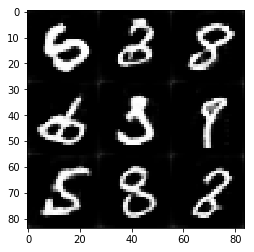

Epoch 2/2-Step 2810... Discriminator Loss: 1.1598... Generator Loss: 0.6267
Epoch 2/2-Step 2820... Discriminator Loss: 1.3759... Generator Loss: 0.5195
Epoch 2/2-Step 2830... Discriminator Loss: 1.0197... Generator Loss: 0.9089
Epoch 2/2-Step 2840... Discriminator Loss: 0.5584... Generator Loss: 1.6436
Epoch 2/2-Step 2850... Discriminator Loss: 1.8377... Generator Loss: 0.3658
Epoch 2/2-Step 2860... Discriminator Loss: 1.2147... Generator Loss: 0.6694
Epoch 2/2-Step 2870... Discriminator Loss: 1.1408... Generator Loss: 0.8225
Epoch 2/2-Step 2880... Discriminator Loss: 0.8431... Generator Loss: 1.3163
Epoch 2/2-Step 2890... Discriminator Loss: 2.2990... Generator Loss: 0.2128
Epoch 2/2-Step 2900... Discriminator Loss: 2.0544... Generator Loss: 0.4308


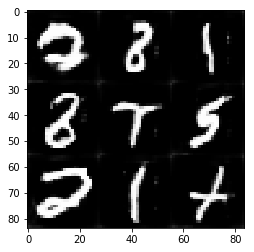

Epoch 2/2-Step 2910... Discriminator Loss: 2.3895... Generator Loss: 0.2125
Epoch 2/2-Step 2920... Discriminator Loss: 0.8310... Generator Loss: 1.0606
Epoch 2/2-Step 2930... Discriminator Loss: 2.2490... Generator Loss: 4.4028
Epoch 2/2-Step 2940... Discriminator Loss: 1.2407... Generator Loss: 1.2902
Epoch 2/2-Step 2950... Discriminator Loss: 2.6363... Generator Loss: 0.2990
Epoch 2/2-Step 2960... Discriminator Loss: 2.1573... Generator Loss: 0.2985
Epoch 2/2-Step 2970... Discriminator Loss: 1.2197... Generator Loss: 0.8472
Epoch 2/2-Step 2980... Discriminator Loss: 1.1789... Generator Loss: 2.3603
Epoch 2/2-Step 2990... Discriminator Loss: 1.4132... Generator Loss: 1.0563
Epoch 2/2-Step 3000... Discriminator Loss: 1.4316... Generator Loss: 2.1424


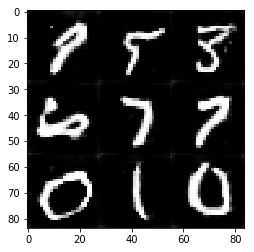

Epoch 2/2-Step 3010... Discriminator Loss: 2.1096... Generator Loss: 0.3688
Epoch 2/2-Step 3020... Discriminator Loss: 2.7113... Generator Loss: 0.1992
Epoch 2/2-Step 3030... Discriminator Loss: 0.7655... Generator Loss: 1.4882
Epoch 2/2-Step 3040... Discriminator Loss: 0.8179... Generator Loss: 1.1351
Epoch 2/2-Step 3050... Discriminator Loss: 2.7765... Generator Loss: 0.1775
Epoch 2/2-Step 3060... Discriminator Loss: 1.6212... Generator Loss: 2.3479
Epoch 2/2-Step 3070... Discriminator Loss: 1.7499... Generator Loss: 0.4827
Epoch 2/2-Step 3080... Discriminator Loss: 1.0921... Generator Loss: 1.2112
Epoch 2/2-Step 3090... Discriminator Loss: 2.1500... Generator Loss: 2.5354
Epoch 2/2-Step 3100... Discriminator Loss: 1.4504... Generator Loss: 0.6992


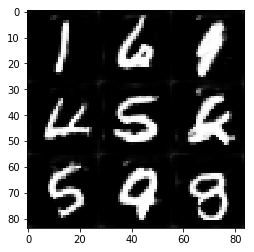

Epoch 2/2-Step 3110... Discriminator Loss: 0.4549... Generator Loss: 2.0005
Epoch 2/2-Step 3120... Discriminator Loss: 2.3352... Generator Loss: 0.1726
Epoch 2/2-Step 3130... Discriminator Loss: 1.8152... Generator Loss: 0.3370
Epoch 2/2-Step 3140... Discriminator Loss: 1.2448... Generator Loss: 0.6605
Epoch 2/2-Step 3150... Discriminator Loss: 1.3393... Generator Loss: 0.6704
Epoch 2/2-Step 3160... Discriminator Loss: 0.3832... Generator Loss: 1.5856
Epoch 2/2-Step 3170... Discriminator Loss: 1.4028... Generator Loss: 0.6451
Epoch 2/2-Step 3180... Discriminator Loss: 0.6644... Generator Loss: 1.8764
Epoch 2/2-Step 3190... Discriminator Loss: 0.9284... Generator Loss: 0.8118
Epoch 2/2-Step 3200... Discriminator Loss: 0.9369... Generator Loss: 1.0325


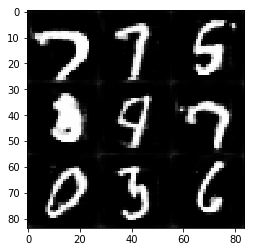

Epoch 2/2-Step 3210... Discriminator Loss: 3.6743... Generator Loss: 0.0663
Epoch 2/2-Step 3220... Discriminator Loss: 1.6144... Generator Loss: 0.5525
Epoch 2/2-Step 3230... Discriminator Loss: 0.6816... Generator Loss: 1.5077
Epoch 2/2-Step 3240... Discriminator Loss: 3.3266... Generator Loss: 0.0811
Epoch 2/2-Step 3250... Discriminator Loss: 1.7431... Generator Loss: 0.5593
Epoch 2/2-Step 3260... Discriminator Loss: 1.4966... Generator Loss: 0.5404
Epoch 2/2-Step 3270... Discriminator Loss: 1.6944... Generator Loss: 0.7823
Epoch 2/2-Step 3280... Discriminator Loss: 1.5925... Generator Loss: 0.6031
Epoch 2/2-Step 3290... Discriminator Loss: 1.2572... Generator Loss: 0.9174
Epoch 2/2-Step 3300... Discriminator Loss: 1.7342... Generator Loss: 0.5187


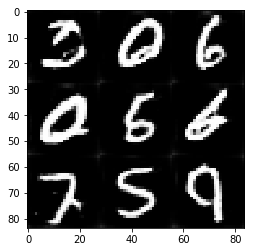

Epoch 2/2-Step 3310... Discriminator Loss: 0.1825... Generator Loss: 4.5827
Epoch 2/2-Step 3320... Discriminator Loss: 1.2775... Generator Loss: 0.7300
Epoch 2/2-Step 3330... Discriminator Loss: 0.8732... Generator Loss: 1.2389
Epoch 2/2-Step 3340... Discriminator Loss: 1.8792... Generator Loss: 0.4560
Epoch 2/2-Step 3350... Discriminator Loss: 0.8879... Generator Loss: 0.9273
Epoch 2/2-Step 3360... Discriminator Loss: 0.4954... Generator Loss: 1.6400
Epoch 2/2-Step 3370... Discriminator Loss: 0.6375... Generator Loss: 1.5675
Epoch 2/2-Step 3380... Discriminator Loss: 1.5641... Generator Loss: 0.5521
Epoch 2/2-Step 3390... Discriminator Loss: 0.4753... Generator Loss: 1.8465
Epoch 2/2-Step 3400... Discriminator Loss: 0.4872... Generator Loss: 1.5438


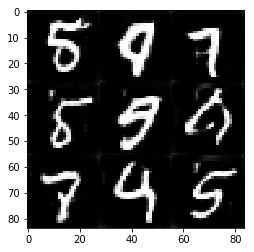

Epoch 2/2-Step 3410... Discriminator Loss: 2.7610... Generator Loss: 0.2020
Epoch 2/2-Step 3420... Discriminator Loss: 1.1922... Generator Loss: 1.7685
Epoch 2/2-Step 3430... Discriminator Loss: 0.8931... Generator Loss: 1.5826
Epoch 2/2-Step 3440... Discriminator Loss: 2.0843... Generator Loss: 0.4748
Epoch 2/2-Step 3450... Discriminator Loss: 1.3589... Generator Loss: 0.6113
Epoch 2/2-Step 3460... Discriminator Loss: 0.7527... Generator Loss: 1.3879
Epoch 2/2-Step 3470... Discriminator Loss: 1.2510... Generator Loss: 0.7047
Epoch 2/2-Step 3480... Discriminator Loss: 1.1979... Generator Loss: 0.8418
Epoch 2/2-Step 3490... Discriminator Loss: 1.6452... Generator Loss: 5.2290
Epoch 2/2-Step 3500... Discriminator Loss: 0.5588... Generator Loss: 1.8905


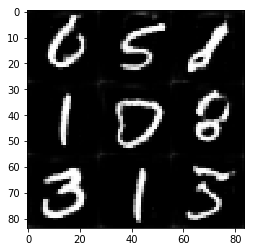

Epoch 2/2-Step 3510... Discriminator Loss: 1.0099... Generator Loss: 1.4121
Epoch 2/2-Step 3520... Discriminator Loss: 2.7485... Generator Loss: 0.2938
Epoch 2/2-Step 3530... Discriminator Loss: 1.3084... Generator Loss: 0.5821
Epoch 2/2-Step 3540... Discriminator Loss: 1.4313... Generator Loss: 3.7524
Epoch 2/2-Step 3550... Discriminator Loss: 0.9619... Generator Loss: 2.8347
Epoch 2/2-Step 3560... Discriminator Loss: 0.8457... Generator Loss: 1.6197
Epoch 2/2-Step 3570... Discriminator Loss: 1.3874... Generator Loss: 0.6073
Epoch 2/2-Step 3580... Discriminator Loss: 1.4953... Generator Loss: 0.6685
Epoch 2/2-Step 3590... Discriminator Loss: 1.2233... Generator Loss: 0.6353
Epoch 2/2-Step 3600... Discriminator Loss: 1.0592... Generator Loss: 1.0551


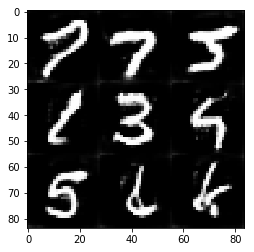

Epoch 2/2-Step 3610... Discriminator Loss: 1.9337... Generator Loss: 0.3964
Epoch 2/2-Step 3620... Discriminator Loss: 0.7413... Generator Loss: 1.2235
Epoch 2/2-Step 3630... Discriminator Loss: 1.1959... Generator Loss: 0.9519
Epoch 2/2-Step 3640... Discriminator Loss: 1.0010... Generator Loss: 1.5190
Epoch 2/2-Step 3650... Discriminator Loss: 2.8820... Generator Loss: 0.1989
Epoch 2/2-Step 3660... Discriminator Loss: 3.1258... Generator Loss: 0.2029
Epoch 2/2-Step 3670... Discriminator Loss: 1.7464... Generator Loss: 0.5479
Epoch 2/2-Step 3680... Discriminator Loss: 1.9657... Generator Loss: 0.3596
Epoch 2/2-Step 3690... Discriminator Loss: 2.0325... Generator Loss: 0.4481
Epoch 2/2-Step 3700... Discriminator Loss: 0.7904... Generator Loss: 1.4904


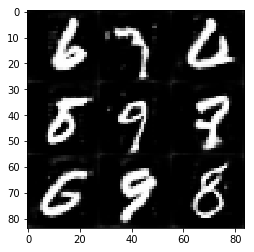

Epoch 2/2-Step 3710... Discriminator Loss: 3.2823... Generator Loss: 0.0943
Epoch 2/2-Step 3720... Discriminator Loss: 3.5929... Generator Loss: 0.1268
Epoch 2/2-Step 3730... Discriminator Loss: 2.5083... Generator Loss: 0.2654
Epoch 2/2-Step 3740... Discriminator Loss: 1.2404... Generator Loss: 0.8706
Epoch 2/2-Step 3750... Discriminator Loss: 0.4249... Generator Loss: 3.3969


In [76]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1-Step 10... Discriminator Loss: 0.0727... Generator Loss: 9.3794
Epoch 1/1-Step 20... Discriminator Loss: 0.0076... Generator Loss: 12.2277
Epoch 1/1-Step 30... Discriminator Loss: 0.0632... Generator Loss: 3.0810
Epoch 1/1-Step 40... Discriminator Loss: 0.0050... Generator Loss: 6.2162
Epoch 1/1-Step 50... Discriminator Loss: 0.0349... Generator Loss: 5.5600
Epoch 1/1-Step 60... Discriminator Loss: 0.0111... Generator Loss: 4.7894
Epoch 1/1-Step 70... Discriminator Loss: 0.0235... Generator Loss: 5.5622
Epoch 1/1-Step 80... Discriminator Loss: 0.1791... Generator Loss: 1.9836
Epoch 1/1-Step 90... Discriminator Loss: 0.0956... Generator Loss: 6.7089
Epoch 1/1-Step 100... Discriminator Loss: 0.6838... Generator Loss: 8.5993


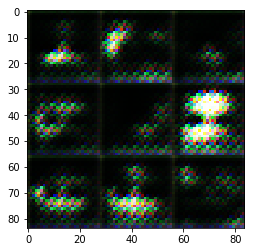

Epoch 1/1-Step 110... Discriminator Loss: 0.5457... Generator Loss: 2.6397
Epoch 1/1-Step 120... Discriminator Loss: 0.8652... Generator Loss: 0.9929
Epoch 1/1-Step 130... Discriminator Loss: 2.4754... Generator Loss: 8.4404
Epoch 1/1-Step 140... Discriminator Loss: 4.9178... Generator Loss: 0.0960
Epoch 1/1-Step 150... Discriminator Loss: 4.8412... Generator Loss: 0.0560
Epoch 1/1-Step 160... Discriminator Loss: 3.6360... Generator Loss: 0.1029
Epoch 1/1-Step 170... Discriminator Loss: 2.6070... Generator Loss: 0.1986
Epoch 1/1-Step 180... Discriminator Loss: 2.5153... Generator Loss: 0.2089
Epoch 1/1-Step 190... Discriminator Loss: 2.1722... Generator Loss: 0.5444
Epoch 1/1-Step 200... Discriminator Loss: 2.5551... Generator Loss: 0.2539


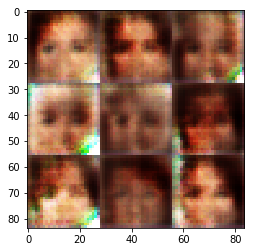

Epoch 1/1-Step 210... Discriminator Loss: 2.0813... Generator Loss: 0.3078
Epoch 1/1-Step 220... Discriminator Loss: 1.9055... Generator Loss: 0.4443
Epoch 1/1-Step 230... Discriminator Loss: 2.5085... Generator Loss: 0.3532
Epoch 1/1-Step 240... Discriminator Loss: 2.2245... Generator Loss: 0.2461
Epoch 1/1-Step 250... Discriminator Loss: 2.1935... Generator Loss: 0.4254
Epoch 1/1-Step 260... Discriminator Loss: 1.9623... Generator Loss: 0.3481
Epoch 1/1-Step 270... Discriminator Loss: 1.9798... Generator Loss: 0.3965
Epoch 1/1-Step 280... Discriminator Loss: 1.8648... Generator Loss: 0.3960
Epoch 1/1-Step 290... Discriminator Loss: 2.0754... Generator Loss: 0.4496
Epoch 1/1-Step 300... Discriminator Loss: 1.7719... Generator Loss: 0.5716


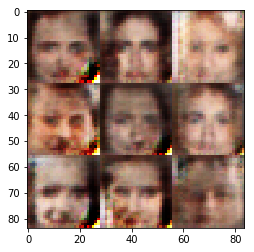

Epoch 1/1-Step 310... Discriminator Loss: 1.6204... Generator Loss: 0.5335
Epoch 1/1-Step 320... Discriminator Loss: 2.0243... Generator Loss: 0.3130
Epoch 1/1-Step 330... Discriminator Loss: 1.6476... Generator Loss: 0.8068
Epoch 1/1-Step 340... Discriminator Loss: 1.7978... Generator Loss: 0.4309
Epoch 1/1-Step 350... Discriminator Loss: 2.0922... Generator Loss: 0.3991
Epoch 1/1-Step 360... Discriminator Loss: 1.6118... Generator Loss: 0.6267
Epoch 1/1-Step 370... Discriminator Loss: 1.6625... Generator Loss: 0.6424
Epoch 1/1-Step 380... Discriminator Loss: 1.7148... Generator Loss: 0.4611
Epoch 1/1-Step 390... Discriminator Loss: 1.5929... Generator Loss: 0.5055
Epoch 1/1-Step 400... Discriminator Loss: 1.6716... Generator Loss: 0.5413


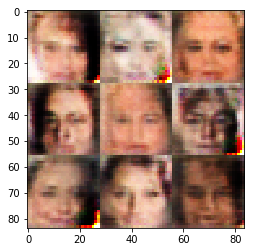

Epoch 1/1-Step 410... Discriminator Loss: 1.5165... Generator Loss: 0.5024
Epoch 1/1-Step 420... Discriminator Loss: 1.6313... Generator Loss: 0.5201
Epoch 1/1-Step 430... Discriminator Loss: 1.6951... Generator Loss: 0.3886
Epoch 1/1-Step 440... Discriminator Loss: 2.0725... Generator Loss: 0.3885
Epoch 1/1-Step 450... Discriminator Loss: 1.7706... Generator Loss: 0.4545
Epoch 1/1-Step 460... Discriminator Loss: 1.6135... Generator Loss: 0.4660
Epoch 1/1-Step 470... Discriminator Loss: 1.7225... Generator Loss: 0.5455
Epoch 1/1-Step 480... Discriminator Loss: 1.8447... Generator Loss: 0.5592
Epoch 1/1-Step 490... Discriminator Loss: 1.5571... Generator Loss: 0.6380
Epoch 1/1-Step 500... Discriminator Loss: 1.6766... Generator Loss: 0.4717


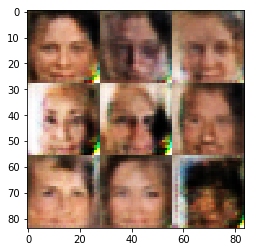

Epoch 1/1-Step 510... Discriminator Loss: 1.6623... Generator Loss: 0.5098
Epoch 1/1-Step 520... Discriminator Loss: 1.7112... Generator Loss: 0.5697
Epoch 1/1-Step 530... Discriminator Loss: 1.7006... Generator Loss: 0.3925
Epoch 1/1-Step 540... Discriminator Loss: 1.5537... Generator Loss: 0.4265
Epoch 1/1-Step 550... Discriminator Loss: 1.7764... Generator Loss: 0.3655
Epoch 1/1-Step 560... Discriminator Loss: 1.3598... Generator Loss: 0.5995
Epoch 1/1-Step 570... Discriminator Loss: 1.4859... Generator Loss: 0.6381
Epoch 1/1-Step 580... Discriminator Loss: 1.6684... Generator Loss: 0.4805
Epoch 1/1-Step 590... Discriminator Loss: 1.7357... Generator Loss: 0.3859
Epoch 1/1-Step 600... Discriminator Loss: 1.7320... Generator Loss: 0.5614


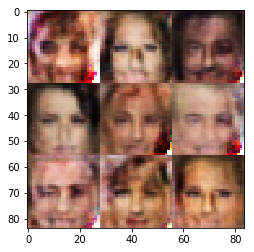

Epoch 1/1-Step 610... Discriminator Loss: 1.7415... Generator Loss: 0.3289
Epoch 1/1-Step 620... Discriminator Loss: 1.7709... Generator Loss: 0.5224
Epoch 1/1-Step 630... Discriminator Loss: 1.6991... Generator Loss: 0.4420
Epoch 1/1-Step 640... Discriminator Loss: 1.6305... Generator Loss: 0.4226
Epoch 1/1-Step 650... Discriminator Loss: 1.3594... Generator Loss: 0.6459
Epoch 1/1-Step 660... Discriminator Loss: 1.5848... Generator Loss: 0.6701
Epoch 1/1-Step 670... Discriminator Loss: 1.5340... Generator Loss: 0.5317
Epoch 1/1-Step 680... Discriminator Loss: 1.4880... Generator Loss: 0.7570
Epoch 1/1-Step 690... Discriminator Loss: 1.7384... Generator Loss: 0.4051
Epoch 1/1-Step 700... Discriminator Loss: 1.6310... Generator Loss: 0.3631


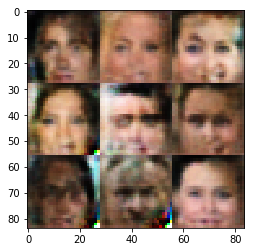

Epoch 1/1-Step 710... Discriminator Loss: 1.5873... Generator Loss: 0.5126
Epoch 1/1-Step 720... Discriminator Loss: 1.5325... Generator Loss: 0.5958
Epoch 1/1-Step 730... Discriminator Loss: 1.3896... Generator Loss: 0.6622
Epoch 1/1-Step 740... Discriminator Loss: 1.5005... Generator Loss: 0.7440
Epoch 1/1-Step 750... Discriminator Loss: 1.7124... Generator Loss: 0.4646
Epoch 1/1-Step 760... Discriminator Loss: 1.6152... Generator Loss: 0.6327
Epoch 1/1-Step 770... Discriminator Loss: 1.6164... Generator Loss: 0.5734
Epoch 1/1-Step 780... Discriminator Loss: 1.7138... Generator Loss: 0.4487
Epoch 1/1-Step 790... Discriminator Loss: 1.5637... Generator Loss: 0.5049
Epoch 1/1-Step 800... Discriminator Loss: 1.6402... Generator Loss: 0.5617


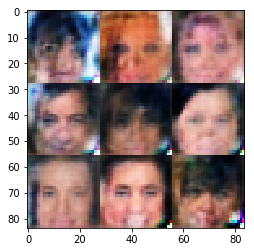

Epoch 1/1-Step 810... Discriminator Loss: 1.7563... Generator Loss: 0.3923
Epoch 1/1-Step 820... Discriminator Loss: 1.7762... Generator Loss: 0.4678
Epoch 1/1-Step 830... Discriminator Loss: 1.5962... Generator Loss: 0.5257
Epoch 1/1-Step 840... Discriminator Loss: 1.6072... Generator Loss: 0.6522
Epoch 1/1-Step 850... Discriminator Loss: 1.6226... Generator Loss: 0.5555
Epoch 1/1-Step 860... Discriminator Loss: 1.5246... Generator Loss: 0.6241
Epoch 1/1-Step 870... Discriminator Loss: 1.6424... Generator Loss: 0.5019
Epoch 1/1-Step 880... Discriminator Loss: 1.5898... Generator Loss: 0.4438
Epoch 1/1-Step 890... Discriminator Loss: 1.6457... Generator Loss: 0.5456
Epoch 1/1-Step 900... Discriminator Loss: 1.6340... Generator Loss: 0.5472


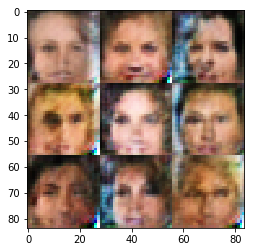

Epoch 1/1-Step 910... Discriminator Loss: 1.5515... Generator Loss: 0.5978
Epoch 1/1-Step 920... Discriminator Loss: 1.6087... Generator Loss: 0.5024
Epoch 1/1-Step 930... Discriminator Loss: 1.6616... Generator Loss: 0.4458
Epoch 1/1-Step 940... Discriminator Loss: 1.9298... Generator Loss: 0.3957
Epoch 1/1-Step 950... Discriminator Loss: 1.5688... Generator Loss: 0.6162
Epoch 1/1-Step 960... Discriminator Loss: 1.5625... Generator Loss: 0.5942
Epoch 1/1-Step 970... Discriminator Loss: 1.6850... Generator Loss: 0.3905
Epoch 1/1-Step 980... Discriminator Loss: 1.5903... Generator Loss: 0.5228
Epoch 1/1-Step 990... Discriminator Loss: 1.5929... Generator Loss: 0.5685
Epoch 1/1-Step 1000... Discriminator Loss: 1.7475... Generator Loss: 0.3601


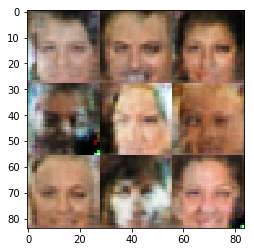

Epoch 1/1-Step 1010... Discriminator Loss: 1.6496... Generator Loss: 0.4886
Epoch 1/1-Step 1020... Discriminator Loss: 1.6259... Generator Loss: 0.4527
Epoch 1/1-Step 1030... Discriminator Loss: 1.6950... Generator Loss: 0.4469
Epoch 1/1-Step 1040... Discriminator Loss: 1.5717... Generator Loss: 0.6022
Epoch 1/1-Step 1050... Discriminator Loss: 1.7170... Generator Loss: 0.5175
Epoch 1/1-Step 1060... Discriminator Loss: 1.9889... Generator Loss: 0.4170
Epoch 1/1-Step 1070... Discriminator Loss: 1.7334... Generator Loss: 0.4863
Epoch 1/1-Step 1080... Discriminator Loss: 1.4844... Generator Loss: 0.6532
Epoch 1/1-Step 1090... Discriminator Loss: 1.5442... Generator Loss: 0.5522
Epoch 1/1-Step 1100... Discriminator Loss: 1.6279... Generator Loss: 0.5473


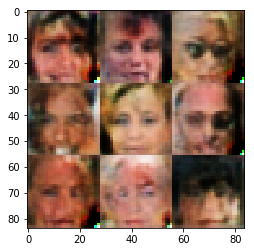

Epoch 1/1-Step 1110... Discriminator Loss: 1.4117... Generator Loss: 0.6320
Epoch 1/1-Step 1120... Discriminator Loss: 1.5478... Generator Loss: 0.5325
Epoch 1/1-Step 1130... Discriminator Loss: 1.4858... Generator Loss: 0.6128
Epoch 1/1-Step 1140... Discriminator Loss: 1.7873... Generator Loss: 0.4608
Epoch 1/1-Step 1150... Discriminator Loss: 1.5082... Generator Loss: 0.5438
Epoch 1/1-Step 1160... Discriminator Loss: 1.6175... Generator Loss: 0.5056
Epoch 1/1-Step 1170... Discriminator Loss: 1.7110... Generator Loss: 0.5155
Epoch 1/1-Step 1180... Discriminator Loss: 1.8326... Generator Loss: 0.4454
Epoch 1/1-Step 1190... Discriminator Loss: 1.5819... Generator Loss: 0.5531
Epoch 1/1-Step 1200... Discriminator Loss: 1.5146... Generator Loss: 0.5342


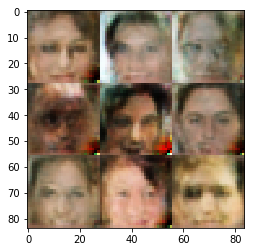

Epoch 1/1-Step 1210... Discriminator Loss: 1.6864... Generator Loss: 0.6659
Epoch 1/1-Step 1220... Discriminator Loss: 1.6513... Generator Loss: 0.4822
Epoch 1/1-Step 1230... Discriminator Loss: 1.6701... Generator Loss: 0.5620
Epoch 1/1-Step 1240... Discriminator Loss: 1.6497... Generator Loss: 0.3909
Epoch 1/1-Step 1250... Discriminator Loss: 1.5540... Generator Loss: 0.6141
Epoch 1/1-Step 1260... Discriminator Loss: 1.6308... Generator Loss: 0.4989
Epoch 1/1-Step 1270... Discriminator Loss: 1.6109... Generator Loss: 0.4821
Epoch 1/1-Step 1280... Discriminator Loss: 1.6181... Generator Loss: 0.4695
Epoch 1/1-Step 1290... Discriminator Loss: 1.6461... Generator Loss: 0.5510
Epoch 1/1-Step 1300... Discriminator Loss: 1.5410... Generator Loss: 0.5102


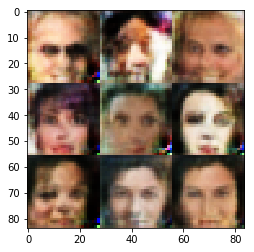

Epoch 1/1-Step 1310... Discriminator Loss: 1.6111... Generator Loss: 0.4807
Epoch 1/1-Step 1320... Discriminator Loss: 1.7205... Generator Loss: 0.5266
Epoch 1/1-Step 1330... Discriminator Loss: 1.6384... Generator Loss: 0.5218
Epoch 1/1-Step 1340... Discriminator Loss: 1.6635... Generator Loss: 0.6340
Epoch 1/1-Step 1350... Discriminator Loss: 1.6056... Generator Loss: 0.5998
Epoch 1/1-Step 1360... Discriminator Loss: 1.5510... Generator Loss: 0.6269
Epoch 1/1-Step 1370... Discriminator Loss: 1.5337... Generator Loss: 0.5658
Epoch 1/1-Step 1380... Discriminator Loss: 1.5314... Generator Loss: 0.5803
Epoch 1/1-Step 1390... Discriminator Loss: 1.5945... Generator Loss: 0.5902
Epoch 1/1-Step 1400... Discriminator Loss: 1.6117... Generator Loss: 0.5127


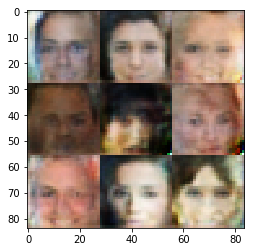

Epoch 1/1-Step 1410... Discriminator Loss: 1.6758... Generator Loss: 0.4837
Epoch 1/1-Step 1420... Discriminator Loss: 1.6267... Generator Loss: 0.5655
Epoch 1/1-Step 1430... Discriminator Loss: 1.5508... Generator Loss: 0.5399
Epoch 1/1-Step 1440... Discriminator Loss: 1.6216... Generator Loss: 0.5033
Epoch 1/1-Step 1450... Discriminator Loss: 1.5129... Generator Loss: 0.5440
Epoch 1/1-Step 1460... Discriminator Loss: 1.5355... Generator Loss: 0.5692
Epoch 1/1-Step 1470... Discriminator Loss: 1.7166... Generator Loss: 0.4328
Epoch 1/1-Step 1480... Discriminator Loss: 1.5201... Generator Loss: 0.6278
Epoch 1/1-Step 1490... Discriminator Loss: 1.5664... Generator Loss: 0.5372
Epoch 1/1-Step 1500... Discriminator Loss: 1.5953... Generator Loss: 0.4794


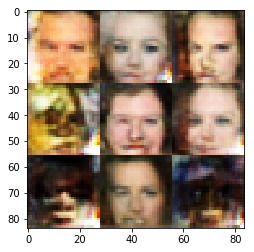

Epoch 1/1-Step 1510... Discriminator Loss: 1.5750... Generator Loss: 0.5716
Epoch 1/1-Step 1520... Discriminator Loss: 1.5316... Generator Loss: 0.6153
Epoch 1/1-Step 1530... Discriminator Loss: 1.5014... Generator Loss: 0.5747
Epoch 1/1-Step 1540... Discriminator Loss: 1.6495... Generator Loss: 0.4497
Epoch 1/1-Step 1550... Discriminator Loss: 1.6587... Generator Loss: 0.4627
Epoch 1/1-Step 1560... Discriminator Loss: 1.5300... Generator Loss: 0.5422
Epoch 1/1-Step 1570... Discriminator Loss: 1.5563... Generator Loss: 0.5813
Epoch 1/1-Step 1580... Discriminator Loss: 1.6175... Generator Loss: 0.6056
Epoch 1/1-Step 1590... Discriminator Loss: 1.5851... Generator Loss: 0.5327
Epoch 1/1-Step 1600... Discriminator Loss: 1.6242... Generator Loss: 0.4894


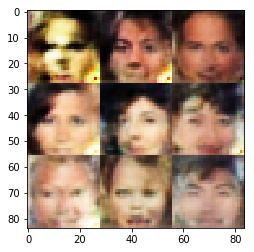

Epoch 1/1-Step 1610... Discriminator Loss: 1.5834... Generator Loss: 0.5294
Epoch 1/1-Step 1620... Discriminator Loss: 1.6298... Generator Loss: 0.5103
Epoch 1/1-Step 1630... Discriminator Loss: 1.6286... Generator Loss: 0.5374
Epoch 1/1-Step 1640... Discriminator Loss: 1.5931... Generator Loss: 0.5947
Epoch 1/1-Step 1650... Discriminator Loss: 1.4749... Generator Loss: 0.5701
Epoch 1/1-Step 1660... Discriminator Loss: 1.7635... Generator Loss: 0.4730
Epoch 1/1-Step 1670... Discriminator Loss: 1.5748... Generator Loss: 0.4961
Epoch 1/1-Step 1680... Discriminator Loss: 1.4538... Generator Loss: 0.5815
Epoch 1/1-Step 1690... Discriminator Loss: 1.5649... Generator Loss: 0.5636
Epoch 1/1-Step 1700... Discriminator Loss: 1.6351... Generator Loss: 0.5656


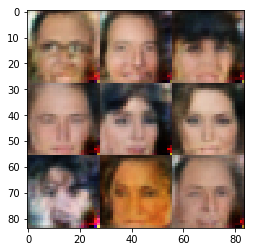

Epoch 1/1-Step 1710... Discriminator Loss: 1.5923... Generator Loss: 0.5038
Epoch 1/1-Step 1720... Discriminator Loss: 1.5411... Generator Loss: 0.5850
Epoch 1/1-Step 1730... Discriminator Loss: 1.5569... Generator Loss: 0.5380
Epoch 1/1-Step 1740... Discriminator Loss: 1.6375... Generator Loss: 0.5668
Epoch 1/1-Step 1750... Discriminator Loss: 1.5744... Generator Loss: 0.5069
Epoch 1/1-Step 1760... Discriminator Loss: 1.4704... Generator Loss: 0.5417
Epoch 1/1-Step 1770... Discriminator Loss: 1.5687... Generator Loss: 0.5396
Epoch 1/1-Step 1780... Discriminator Loss: 1.5869... Generator Loss: 0.5047
Epoch 1/1-Step 1790... Discriminator Loss: 1.7663... Generator Loss: 0.4312
Epoch 1/1-Step 1800... Discriminator Loss: 1.4238... Generator Loss: 0.6334


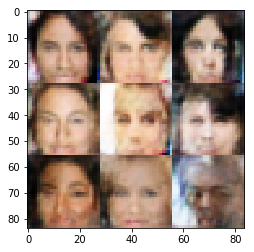

Epoch 1/1-Step 1810... Discriminator Loss: 1.5628... Generator Loss: 0.5775
Epoch 1/1-Step 1820... Discriminator Loss: 1.6301... Generator Loss: 0.5084
Epoch 1/1-Step 1830... Discriminator Loss: 1.5955... Generator Loss: 0.5984
Epoch 1/1-Step 1840... Discriminator Loss: 1.5123... Generator Loss: 0.6310
Epoch 1/1-Step 1850... Discriminator Loss: 1.4927... Generator Loss: 0.5799
Epoch 1/1-Step 1860... Discriminator Loss: 1.5843... Generator Loss: 0.6180
Epoch 1/1-Step 1870... Discriminator Loss: 1.5226... Generator Loss: 0.5901
Epoch 1/1-Step 1880... Discriminator Loss: 1.7258... Generator Loss: 0.4123
Epoch 1/1-Step 1890... Discriminator Loss: 1.4861... Generator Loss: 0.5732
Epoch 1/1-Step 1900... Discriminator Loss: 1.6749... Generator Loss: 0.5128


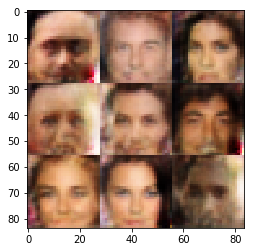

Epoch 1/1-Step 1910... Discriminator Loss: 1.5475... Generator Loss: 0.6490
Epoch 1/1-Step 1920... Discriminator Loss: 1.5889... Generator Loss: 0.5187
Epoch 1/1-Step 1930... Discriminator Loss: 1.4351... Generator Loss: 0.5514
Epoch 1/1-Step 1940... Discriminator Loss: 1.6251... Generator Loss: 0.5055
Epoch 1/1-Step 1950... Discriminator Loss: 1.6869... Generator Loss: 0.5026
Epoch 1/1-Step 1960... Discriminator Loss: 1.6051... Generator Loss: 0.5311
Epoch 1/1-Step 1970... Discriminator Loss: 1.5428... Generator Loss: 0.6195
Epoch 1/1-Step 1980... Discriminator Loss: 1.5524... Generator Loss: 0.7520
Epoch 1/1-Step 1990... Discriminator Loss: 1.5038... Generator Loss: 0.6006
Epoch 1/1-Step 2000... Discriminator Loss: 1.4429... Generator Loss: 0.5845


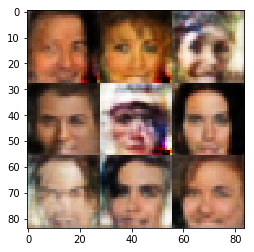

Epoch 1/1-Step 2010... Discriminator Loss: 1.6835... Generator Loss: 0.5229
Epoch 1/1-Step 2020... Discriminator Loss: 1.6322... Generator Loss: 0.4383
Epoch 1/1-Step 2030... Discriminator Loss: 1.5226... Generator Loss: 0.6373
Epoch 1/1-Step 2040... Discriminator Loss: 1.5326... Generator Loss: 0.5994
Epoch 1/1-Step 2050... Discriminator Loss: 1.6601... Generator Loss: 0.4407
Epoch 1/1-Step 2060... Discriminator Loss: 1.4935... Generator Loss: 0.6701
Epoch 1/1-Step 2070... Discriminator Loss: 1.4603... Generator Loss: 0.6488
Epoch 1/1-Step 2080... Discriminator Loss: 1.5661... Generator Loss: 0.6325
Epoch 1/1-Step 2090... Discriminator Loss: 1.5542... Generator Loss: 0.5592
Epoch 1/1-Step 2100... Discriminator Loss: 1.4832... Generator Loss: 0.5962


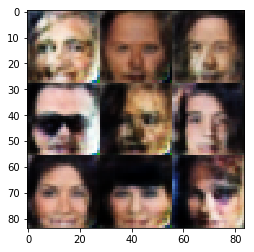

Epoch 1/1-Step 2110... Discriminator Loss: 1.6266... Generator Loss: 0.4967
Epoch 1/1-Step 2120... Discriminator Loss: 1.4847... Generator Loss: 0.6371
Epoch 1/1-Step 2130... Discriminator Loss: 1.6838... Generator Loss: 0.6783
Epoch 1/1-Step 2140... Discriminator Loss: 1.4585... Generator Loss: 0.6055
Epoch 1/1-Step 2150... Discriminator Loss: 1.5668... Generator Loss: 0.6090
Epoch 1/1-Step 2160... Discriminator Loss: 1.5711... Generator Loss: 0.5704
Epoch 1/1-Step 2170... Discriminator Loss: 1.6091... Generator Loss: 0.4876
Epoch 1/1-Step 2180... Discriminator Loss: 1.5204... Generator Loss: 0.5957
Epoch 1/1-Step 2190... Discriminator Loss: 1.5270... Generator Loss: 0.6346
Epoch 1/1-Step 2200... Discriminator Loss: 1.4999... Generator Loss: 0.4813


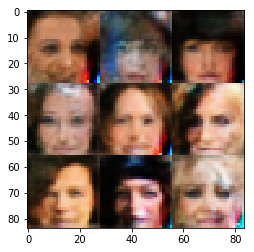

Epoch 1/1-Step 2210... Discriminator Loss: 1.5486... Generator Loss: 0.5724
Epoch 1/1-Step 2220... Discriminator Loss: 1.5582... Generator Loss: 0.5687
Epoch 1/1-Step 2230... Discriminator Loss: 1.6047... Generator Loss: 0.4993
Epoch 1/1-Step 2240... Discriminator Loss: 1.4981... Generator Loss: 0.5811
Epoch 1/1-Step 2250... Discriminator Loss: 1.5765... Generator Loss: 0.5936
Epoch 1/1-Step 2260... Discriminator Loss: 1.4636... Generator Loss: 0.5365
Epoch 1/1-Step 2270... Discriminator Loss: 1.5911... Generator Loss: 0.5017
Epoch 1/1-Step 2280... Discriminator Loss: 1.5097... Generator Loss: 0.5504
Epoch 1/1-Step 2290... Discriminator Loss: 1.5114... Generator Loss: 0.6006
Epoch 1/1-Step 2300... Discriminator Loss: 1.5466... Generator Loss: 0.4722


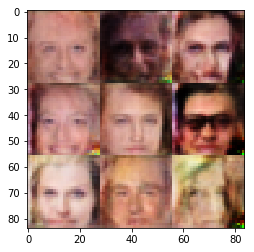

Epoch 1/1-Step 2310... Discriminator Loss: 1.5663... Generator Loss: 0.5642
Epoch 1/1-Step 2320... Discriminator Loss: 1.5616... Generator Loss: 0.5305
Epoch 1/1-Step 2330... Discriminator Loss: 1.5452... Generator Loss: 0.4717
Epoch 1/1-Step 2340... Discriminator Loss: 1.5097... Generator Loss: 0.5591
Epoch 1/1-Step 2350... Discriminator Loss: 1.5448... Generator Loss: 0.6524
Epoch 1/1-Step 2360... Discriminator Loss: 1.5724... Generator Loss: 0.5009
Epoch 1/1-Step 2370... Discriminator Loss: 1.5217... Generator Loss: 0.6050
Epoch 1/1-Step 2380... Discriminator Loss: 1.4962... Generator Loss: 0.5783
Epoch 1/1-Step 2390... Discriminator Loss: 1.5700... Generator Loss: 0.6142
Epoch 1/1-Step 2400... Discriminator Loss: 1.4578... Generator Loss: 0.5684


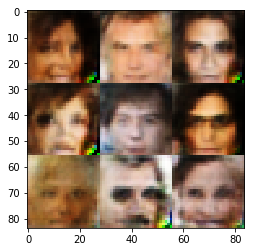

Epoch 1/1-Step 2410... Discriminator Loss: 1.5131... Generator Loss: 0.5926
Epoch 1/1-Step 2420... Discriminator Loss: 1.5050... Generator Loss: 0.7034
Epoch 1/1-Step 2430... Discriminator Loss: 1.5339... Generator Loss: 0.5644
Epoch 1/1-Step 2440... Discriminator Loss: 1.4892... Generator Loss: 0.6411
Epoch 1/1-Step 2450... Discriminator Loss: 1.4928... Generator Loss: 0.5780
Epoch 1/1-Step 2460... Discriminator Loss: 1.4603... Generator Loss: 0.5994
Epoch 1/1-Step 2470... Discriminator Loss: 1.5285... Generator Loss: 0.6405
Epoch 1/1-Step 2480... Discriminator Loss: 1.4590... Generator Loss: 0.6900
Epoch 1/1-Step 2490... Discriminator Loss: 1.5542... Generator Loss: 0.6006
Epoch 1/1-Step 2500... Discriminator Loss: 1.4520... Generator Loss: 0.7350


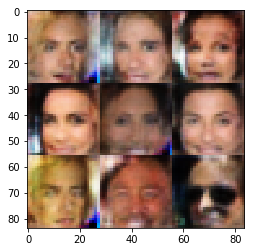

Epoch 1/1-Step 2510... Discriminator Loss: 1.5680... Generator Loss: 0.5199
Epoch 1/1-Step 2520... Discriminator Loss: 1.4815... Generator Loss: 0.5623
Epoch 1/1-Step 2530... Discriminator Loss: 1.4943... Generator Loss: 0.6459
Epoch 1/1-Step 2540... Discriminator Loss: 1.4227... Generator Loss: 0.6303
Epoch 1/1-Step 2550... Discriminator Loss: 1.4773... Generator Loss: 0.6954
Epoch 1/1-Step 2560... Discriminator Loss: 1.5832... Generator Loss: 0.6401
Epoch 1/1-Step 2570... Discriminator Loss: 1.5105... Generator Loss: 0.6780
Epoch 1/1-Step 2580... Discriminator Loss: 1.5102... Generator Loss: 0.5282
Epoch 1/1-Step 2590... Discriminator Loss: 1.5095... Generator Loss: 0.5546
Epoch 1/1-Step 2600... Discriminator Loss: 1.4809... Generator Loss: 0.5799


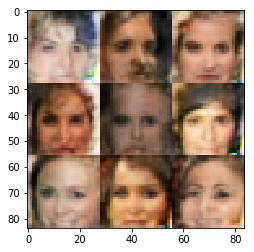

Epoch 1/1-Step 2610... Discriminator Loss: 1.4600... Generator Loss: 0.6504
Epoch 1/1-Step 2620... Discriminator Loss: 1.5427... Generator Loss: 0.6289
Epoch 1/1-Step 2630... Discriminator Loss: 1.6130... Generator Loss: 0.5409
Epoch 1/1-Step 2640... Discriminator Loss: 1.5036... Generator Loss: 0.5403
Epoch 1/1-Step 2650... Discriminator Loss: 1.5142... Generator Loss: 0.6227
Epoch 1/1-Step 2660... Discriminator Loss: 1.4610... Generator Loss: 0.6740
Epoch 1/1-Step 2670... Discriminator Loss: 1.5189... Generator Loss: 0.6304
Epoch 1/1-Step 2680... Discriminator Loss: 1.4857... Generator Loss: 0.5588
Epoch 1/1-Step 2690... Discriminator Loss: 1.4780... Generator Loss: 0.6343
Epoch 1/1-Step 2700... Discriminator Loss: 1.4853... Generator Loss: 0.6399


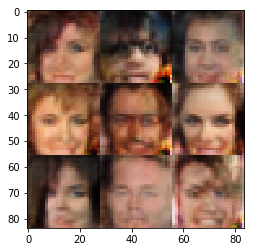

Epoch 1/1-Step 2710... Discriminator Loss: 1.4660... Generator Loss: 0.5470
Epoch 1/1-Step 2720... Discriminator Loss: 1.6547... Generator Loss: 0.5747
Epoch 1/1-Step 2730... Discriminator Loss: 1.6056... Generator Loss: 0.5382
Epoch 1/1-Step 2740... Discriminator Loss: 1.5344... Generator Loss: 0.6217
Epoch 1/1-Step 2750... Discriminator Loss: 1.4596... Generator Loss: 0.6441
Epoch 1/1-Step 2760... Discriminator Loss: 1.5443... Generator Loss: 0.5064
Epoch 1/1-Step 2770... Discriminator Loss: 1.5773... Generator Loss: 0.5066
Epoch 1/1-Step 2780... Discriminator Loss: 1.5259... Generator Loss: 0.6386
Epoch 1/1-Step 2790... Discriminator Loss: 1.5320... Generator Loss: 0.5977
Epoch 1/1-Step 2800... Discriminator Loss: 1.5102... Generator Loss: 0.6136


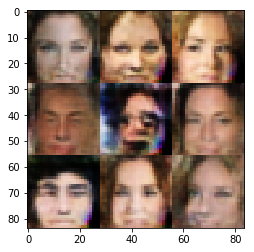

Epoch 1/1-Step 2810... Discriminator Loss: 1.4854... Generator Loss: 0.6670
Epoch 1/1-Step 2820... Discriminator Loss: 1.5372... Generator Loss: 0.6835
Epoch 1/1-Step 2830... Discriminator Loss: 1.5328... Generator Loss: 0.7039
Epoch 1/1-Step 2840... Discriminator Loss: 1.6758... Generator Loss: 0.5030
Epoch 1/1-Step 2850... Discriminator Loss: 1.3977... Generator Loss: 0.6095
Epoch 1/1-Step 2860... Discriminator Loss: 1.6221... Generator Loss: 0.5926
Epoch 1/1-Step 2870... Discriminator Loss: 1.5251... Generator Loss: 0.6481
Epoch 1/1-Step 2880... Discriminator Loss: 1.4604... Generator Loss: 0.5213
Epoch 1/1-Step 2890... Discriminator Loss: 1.5202... Generator Loss: 0.5007
Epoch 1/1-Step 2900... Discriminator Loss: 1.4630... Generator Loss: 0.6140


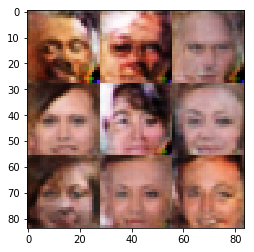

Epoch 1/1-Step 2910... Discriminator Loss: 1.3858... Generator Loss: 0.6565
Epoch 1/1-Step 2920... Discriminator Loss: 1.4337... Generator Loss: 0.7014
Epoch 1/1-Step 2930... Discriminator Loss: 1.5349... Generator Loss: 0.5818
Epoch 1/1-Step 2940... Discriminator Loss: 1.3969... Generator Loss: 0.6059
Epoch 1/1-Step 2950... Discriminator Loss: 1.5284... Generator Loss: 0.6069
Epoch 1/1-Step 2960... Discriminator Loss: 1.4804... Generator Loss: 0.5743
Epoch 1/1-Step 2970... Discriminator Loss: 1.4891... Generator Loss: 0.7033
Epoch 1/1-Step 2980... Discriminator Loss: 1.5484... Generator Loss: 0.5540
Epoch 1/1-Step 2990... Discriminator Loss: 1.5461... Generator Loss: 0.6244
Epoch 1/1-Step 3000... Discriminator Loss: 1.4820... Generator Loss: 0.6587


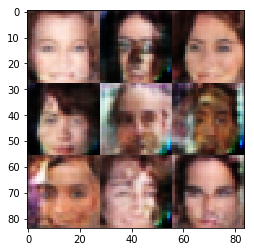

Epoch 1/1-Step 3010... Discriminator Loss: 1.5879... Generator Loss: 0.5517
Epoch 1/1-Step 3020... Discriminator Loss: 1.4577... Generator Loss: 0.6005
Epoch 1/1-Step 3030... Discriminator Loss: 1.4562... Generator Loss: 0.6765
Epoch 1/1-Step 3040... Discriminator Loss: 1.5195... Generator Loss: 0.6498
Epoch 1/1-Step 3050... Discriminator Loss: 1.4982... Generator Loss: 0.6116
Epoch 1/1-Step 3060... Discriminator Loss: 1.4935... Generator Loss: 0.6510
Epoch 1/1-Step 3070... Discriminator Loss: 1.5386... Generator Loss: 0.5516
Epoch 1/1-Step 3080... Discriminator Loss: 1.4903... Generator Loss: 0.6672
Epoch 1/1-Step 3090... Discriminator Loss: 1.5832... Generator Loss: 0.5869
Epoch 1/1-Step 3100... Discriminator Loss: 1.4703... Generator Loss: 0.6179


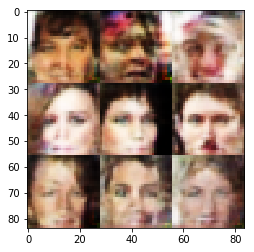

Epoch 1/1-Step 3110... Discriminator Loss: 1.5633... Generator Loss: 0.5450
Epoch 1/1-Step 3120... Discriminator Loss: 1.5169... Generator Loss: 0.5910
Epoch 1/1-Step 3130... Discriminator Loss: 1.5457... Generator Loss: 0.6699
Epoch 1/1-Step 3140... Discriminator Loss: 1.4988... Generator Loss: 0.5929
Epoch 1/1-Step 3150... Discriminator Loss: 1.4436... Generator Loss: 0.6491


KeyboardInterrupt: 

In [94]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.